In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import train_test_split    
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings


warnings.filterwarnings("ignore")  
pd.set_option('display.max_columns', None) 

In [2]:
df = pd.read_csv(r'../DataCleaning/ElectroTech Forecasting Data.csv')

In [3]:
df.head()

,Product_ID,Category,Price,Date,Season,Market_Trend_Index,Competitor_Activity_Score,Consumer_Confidence_Index,Product_Specification_1,Product_Specification_2,Sales_Volume
0,1103,Laptop,105.32,2009-01-01,Winter,-1.859160,0.546694,84.680465,Spec_C,Long-Battery-Life,49
1,1436,Tablet,145.55,2009-01-01,Winter,-0.345587,0.940428,42.919288,Spec_C,Lightweight,69
2,1271,Smartphone,97.82,2009-01-01,Winter,-0.384738,0.751155,55.191268,Spec_B,Lightweight,50
3,1107,Laptop,64.00,2009-01-01,Winter,0.716763,0.125939,88.746454,Spec_B,High-Resolution,28
4,1072,Tablet,67.83,2009-01-01,Winter,-0.242074,-0.412932,67.947536,Spec_A,Long-Battery-Life,81


In [4]:
df['Date'] = pd.to_datetime(df['Date'], format='%Y-%m-%d')

In [5]:
# print out all object columns and their count 
for col in df.select_dtypes(include =['object']).columns:
    print(f"Values: {df[col].value_counts()}")

Values: Category
Tablet         34370
Accessories    34041
Smartphone     33980
Laptop         33802
Name: count, dtype: int64
Values: Season
Spring    34642
Summer    34159
Fall      33743
Winter    33649
Name: count, dtype: int64
Values: Product_Specification_1
Spec_C    45652
Spec_B    45569
Spec_A    44972
Name: count, dtype: int64
Values: Product_Specification_2
Lightweight          45599
Long-Battery-Life    45321
High-Resolution      45273
Name: count, dtype: int64


In [6]:
# Total sales per category
total_sales_by_date_category = df.groupby(['Date', 'Category']).sum()['Sales_Volume'].reset_index()
print(total_sales_by_date_category)

            Date     Category  Sales_Volume
0     2009-01-01  Accessories           619
1     2009-01-01       Laptop           790
2     2009-01-01   Smartphone           564
3     2009-01-01       Tablet           768
4     2009-01-02  Accessories           227
...          ...          ...           ...
17450 2020-12-29       Laptop          1456
17451 2020-12-29   Smartphone          1744
17452 2020-12-29       Tablet          2282
17453 2020-12-30  Accessories           421
17454 2020-12-30   Smartphone           287

[17455 rows x 3 columns]


In [7]:
# Total sales per category
total_sales_per_category = df.groupby('Category')['Sales_Volume'].sum().reset_index()
total_sales_per_category = total_sales_per_category.sort_values(by='Sales_Volume', ascending=False)
print(total_sales_per_category)


      Category  Sales_Volume
3       Tablet       4202440
0  Accessories       4164686
2   Smartphone       4162098
1       Laptop       4127880


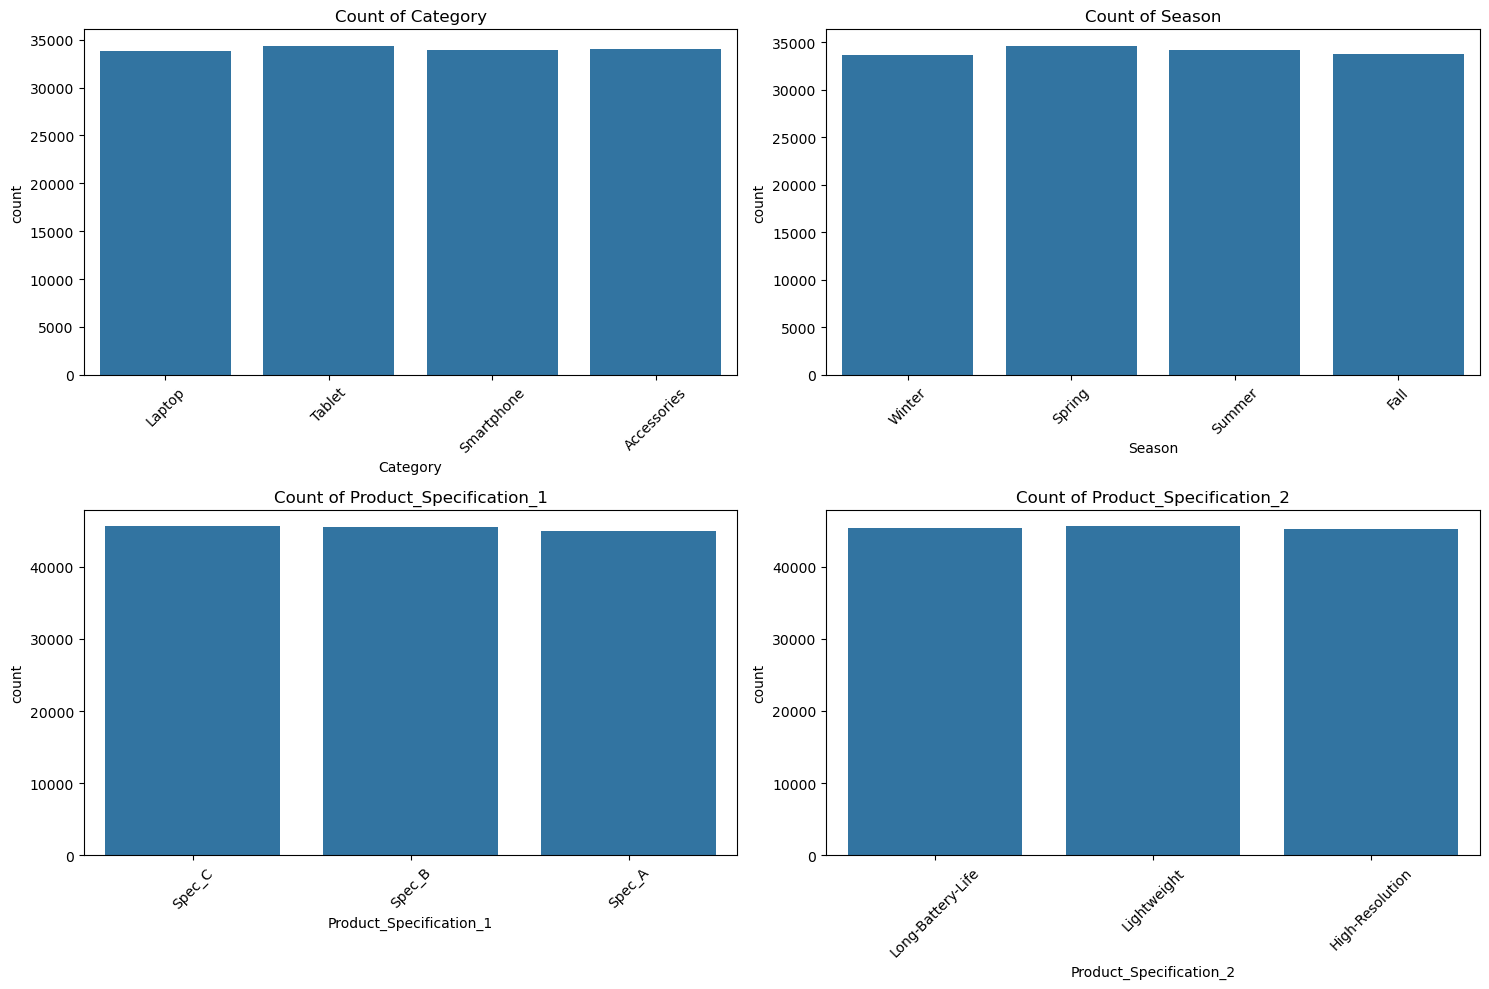

In [8]:
# Visualize object columns and their counts
object_cols = df.select_dtypes(include=['object']).columns

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

positions = [(0, 0), (0, 1), (1, 0), (1, 1)]

for i, pos in enumerate(positions):
    if i >= len(object_cols):
        break
    col = object_cols[i]
    sns.countplot(data=df, x=col, ax=axes[pos[0], pos[1]])
    axes[pos[0], pos[1]].set_title(f'Count of {col}')
    axes[pos[0], pos[1]].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

From the figures above, the dataset is balanced in terms of object column counts distribution

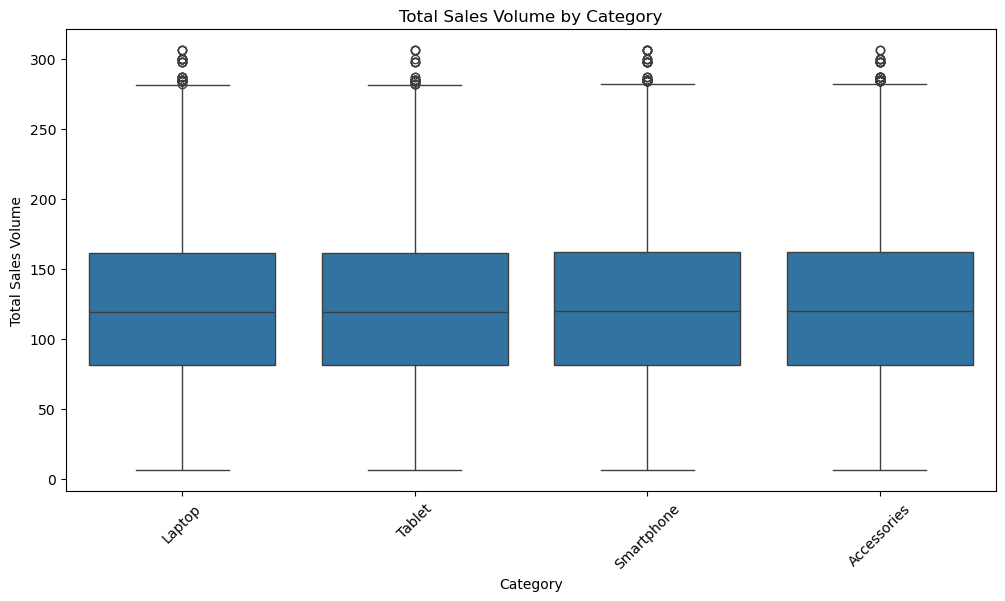

In [9]:
# visualize category against sales volume
plt.figure(figsize=(12, 6))
sns.boxplot(data=df, x='Category', y='Sales_Volume')
plt.title('Total Sales Volume by Category')
plt.xlabel('Category')
plt.ylabel('Total Sales Volume')
plt.xticks(rotation=45)
plt.show()   

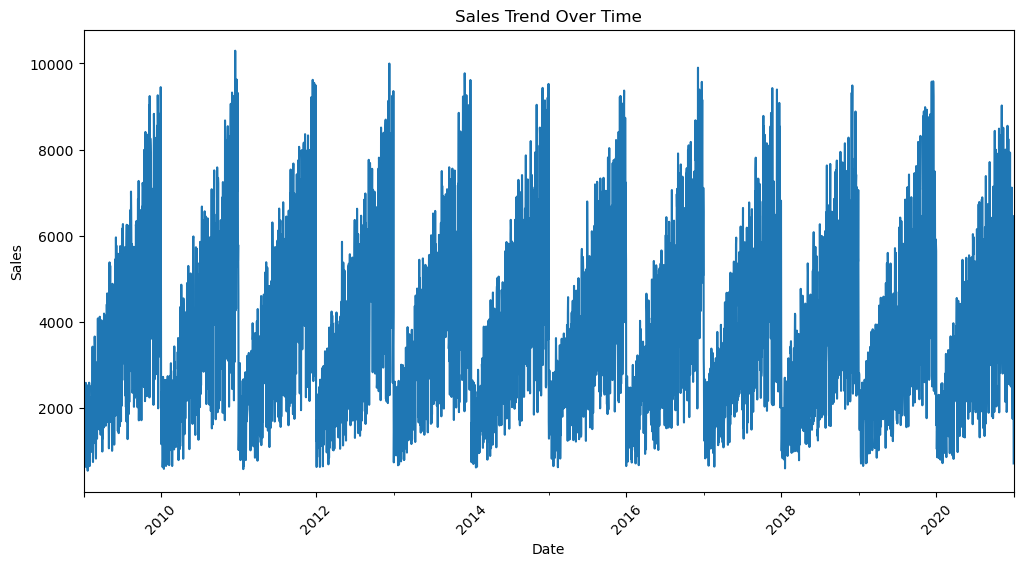

In [10]:
# visualize sales trend over time 
plt.figure(figsize=(12, 6))
df.groupby('Date')['Sales_Volume'].sum().plot()
plt.title('Sales Trend Over Time')
plt.xlabel('Date')
plt.ylabel('Sales')
plt.xticks(rotation=45)
plt.show()

The trend shows a general increase in sales over time, with some fluctuations. It is tightly packed because it shows sales of all categories over time. To get a better picture, the categories will be broken down and stored in different dataframes to better understand each category's sales trend. 

To get better and more specific information about the data, the categories will be split into different columns first and studied individually to understand trends better and specifically. 

### **Trend Analysis**

In [11]:
# create separate dataframes for each category
tablet_df = df[df['Category'] == 'Tablet']
laptop_df = df[df['Category'] == 'Laptop']
smartphone_df = df[df['Category'] == 'Smartphone']
accessory_df = df[df['Category'] == 'Accessories']

# Get daily mean for all categories and store in new column avergae sales 
# Group by Category and Day, compute average metrics
tablet_df = tablet_df.groupby(['Category', 'Date']).agg({
    'Sales_Volume': 'mean',
    'Price': 'mean',
    'Market_Trend_Index': 'mean',
    'Competitor_Activity_Score': 'mean',
    'Consumer_Confidence_Index': 'mean'
}).reset_index()

laptop_df = laptop_df.groupby(['Category', 'Date']).agg({
    'Sales_Volume': 'mean',
    'Price': 'mean',
    'Market_Trend_Index': 'mean',
    'Competitor_Activity_Score': 'mean',
    'Consumer_Confidence_Index': 'mean'
}).reset_index()    

smartphone_df = smartphone_df.groupby(['Category', 'Date']).agg({
    'Sales_Volume': 'mean',
    'Price': 'mean',
    'Market_Trend_Index': 'mean',               
    'Competitor_Activity_Score': 'mean',
    'Consumer_Confidence_Index': 'mean'
}).reset_index()

accessory_df = accessory_df.groupby(['Category', 'Date']).agg({
    'Sales_Volume': 'mean',
    'Price': 'mean',
    'Market_Trend_Index': 'mean',
    'Competitor_Activity_Score': 'mean',
    'Consumer_Confidence_Index': 'mean'
}).reset_index()

# Save all dataframes to csv files
tablet_df.to_csv('tablet_data.csv', index=False)
laptop_df.to_csv('laptop_data.csv', index=False)
smartphone_df.to_csv('smartphone_data.csv', index=False)
accessory_df.to_csv('accessory_data.csv', index=False)

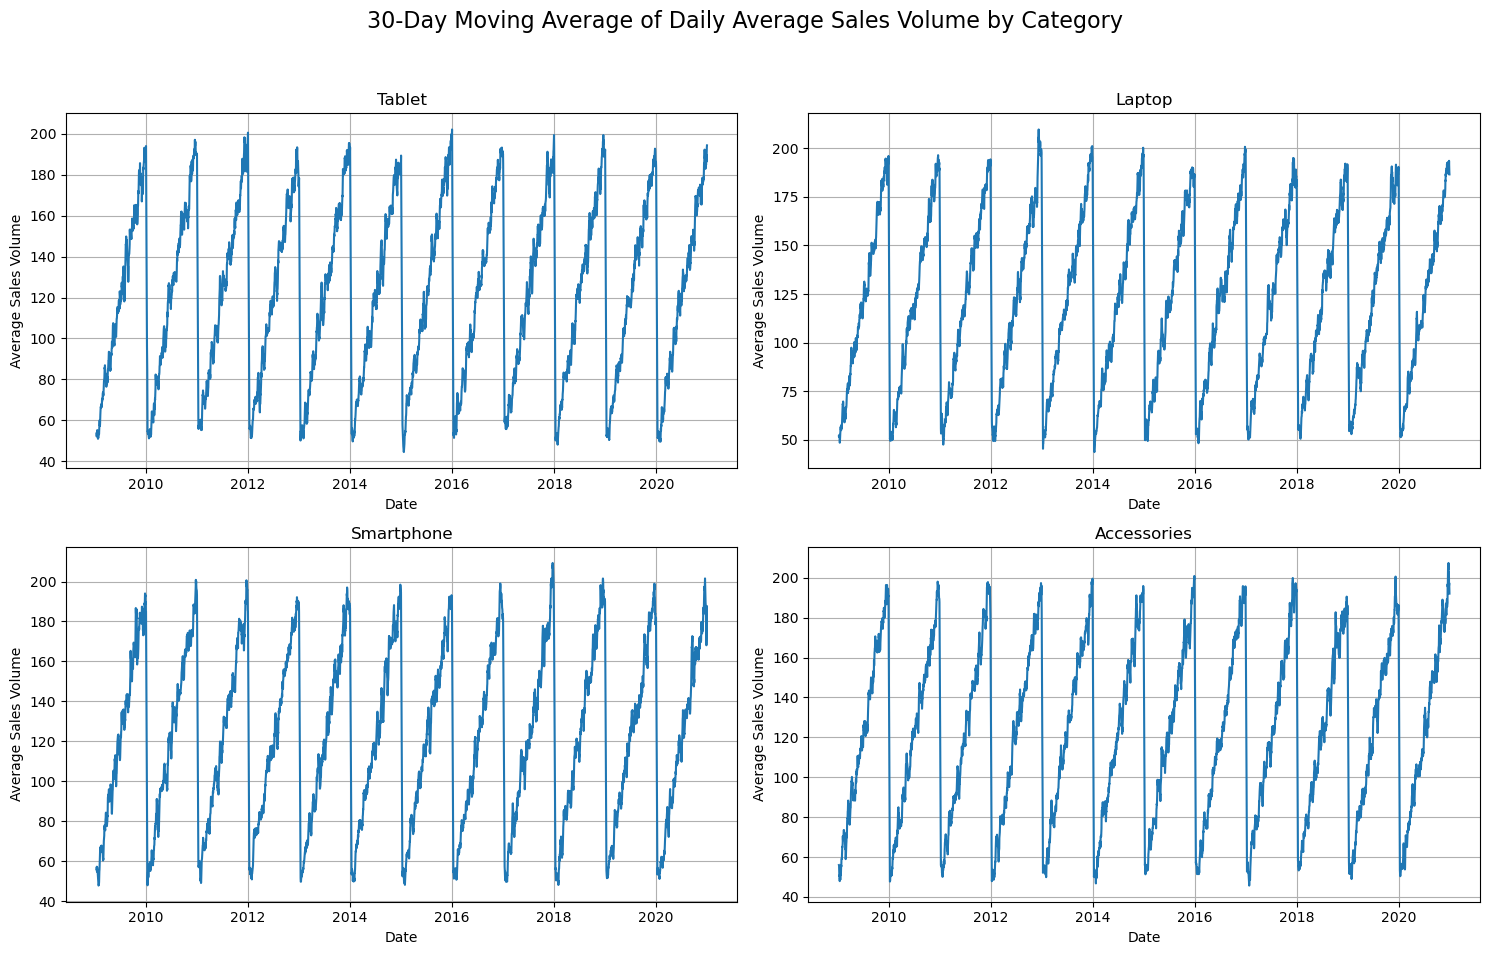

In [12]:
# Group by Date and Category, then calculate average Sales for each day per category
daily_avg_tablet = tablet_df.groupby(['Date', 'Category'])['Sales_Volume'].mean().reset_index()
daily_avg_laptop = laptop_df.groupby(['Date', 'Category'])['Sales_Volume'].mean().reset_index()
daily_avg_smartphone = smartphone_df.groupby(['Date', 'Category'])['Sales_Volume'].mean().reset_index()
daily_avg_accessory = accessory_df.groupby(['Date', 'Category'])['Sales_Volume'].mean().reset_index()

# Pivot so each category becomes a column
pivoted_tablet = daily_avg_tablet.pivot(index='Date', columns='Category', values='Sales_Volume')
pivoted_laptop = daily_avg_laptop.pivot(index='Date', columns='Category', values='Sales_Volume')
pivoted_smartphone = daily_avg_smartphone.pivot(index='Date', columns='Category', values='Sales_Volume')
pivoted_accessory = daily_avg_accessory.pivot(index='Date', columns='Category', values='Sales_Volume')

# Apply a moving average (e.g., 30-day window)
smoothed_tablet = pivoted_tablet.rolling(window=10).mean()
smoothed_laptop = pivoted_laptop.rolling(window=10).mean()
smoothed_smartphone = pivoted_smartphone.rolling(window=10).mean()
smoothed_accessory = pivoted_accessory.rolling(window=10).mean()

# Prepare the data and titles
data_list = [
    (smoothed_tablet, 'Tablet'),
    (smoothed_laptop, 'Laptop'),
    (smoothed_smartphone, 'Smartphone'),
    (smoothed_accessory, 'Accessories')
]

# Create subplots
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('30-Day Moving Average of Daily Average Sales Volume by Category', fontsize=16)

# Flatten axes array for easy iteration
axs = axs.flatten()

# Loop through data and plot
for ax, (data, title) in zip(axs, data_list):
    ax.plot(data)
    ax.set_title(title)
    ax.set_ylabel('Average Sales Volume')
    ax.set_xlabel('Date')
    ax.grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

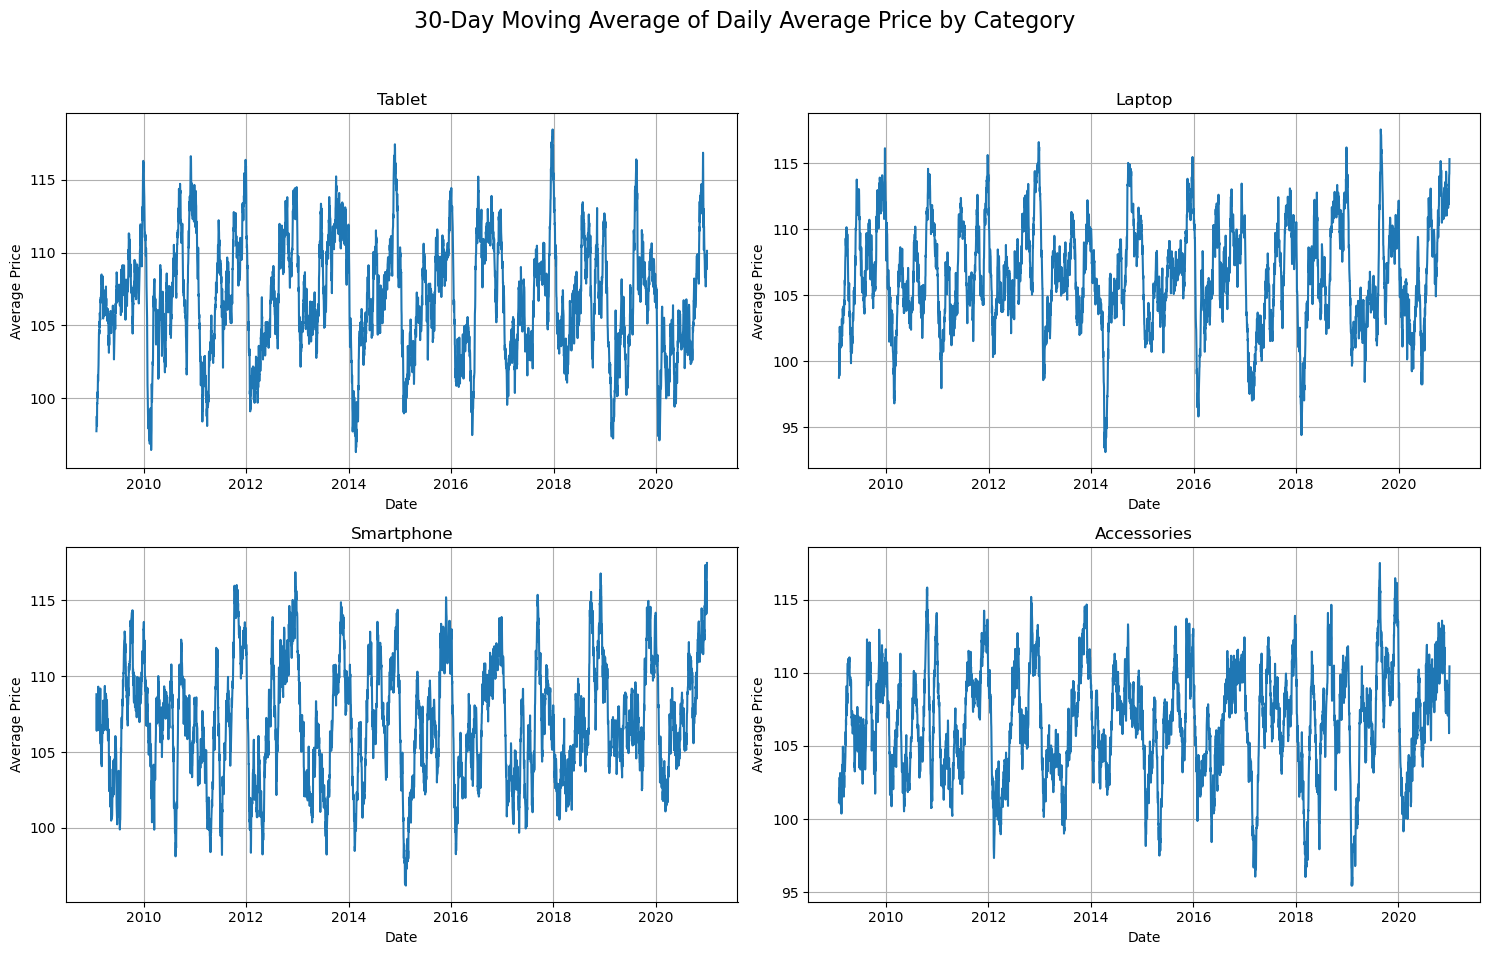

In [13]:
# Group by Date and Category, then calculate average price for each day per category
daily_avg_price_tablet = tablet_df.groupby(['Date', 'Category'])['Price'].mean().reset_index()
daily_avg_price_laptop = laptop_df.groupby(['Date', 'Category'])['Price'].mean().reset_index()
daily_avg_price_smartphone = smartphone_df.groupby(['Date', 'Category'])['Price'].mean().reset_index()
daily_avg_price_accessory = accessory_df.groupby(['Date', 'Category'])['Price'].mean().reset_index()    

# Pivot so each category becomes a column
pivoted_price_tablet = daily_avg_price_tablet.pivot(index='Date', columns='Category', values='Price')
pivoted_price_laptop = daily_avg_price_laptop.pivot(index='Date', columns='Category', values='Price')
pivoted_price_smartphone = daily_avg_price_smartphone.pivot(index='Date', columns='Category', values='Price')
pivoted_price_accessory = daily_avg_price_accessory.pivot(index='Date', columns='Category', values='Price')

# Apply a moving average (e.g., 30-day window)
smoothed_price_tablet = pivoted_price_tablet.rolling(window=30).mean()
smoothed_price_laptop = pivoted_price_laptop.rolling(window=30).mean()
smoothed_price_smartphone = pivoted_price_smartphone.rolling(window=30).mean()
smoothed_price_accessory = pivoted_price_accessory.rolling(window=30).mean()    

# List of (data, title) pairs
price_data_list = [
    (smoothed_price_tablet, 'Tablet'),
    (smoothed_price_laptop, 'Laptop'),
    (smoothed_price_smartphone, 'Smartphone'),
    (smoothed_price_accessory, 'Accessories')
]

# Create a 2x2 subplot figure
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('30-Day Moving Average of Daily Average Price by Category', fontsize=16)

# Flatten axes array for easy iteration
axs = axs.flatten()

# Loop to plot each category
for ax, (data, title) in zip(axs, price_data_list):
    ax.plot(data)
    ax.set_title(title)
    ax.set_ylabel('Average Price')
    ax.set_xlabel('Date')
    ax.grid(True)

# Adjust layout to prevent overlap
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

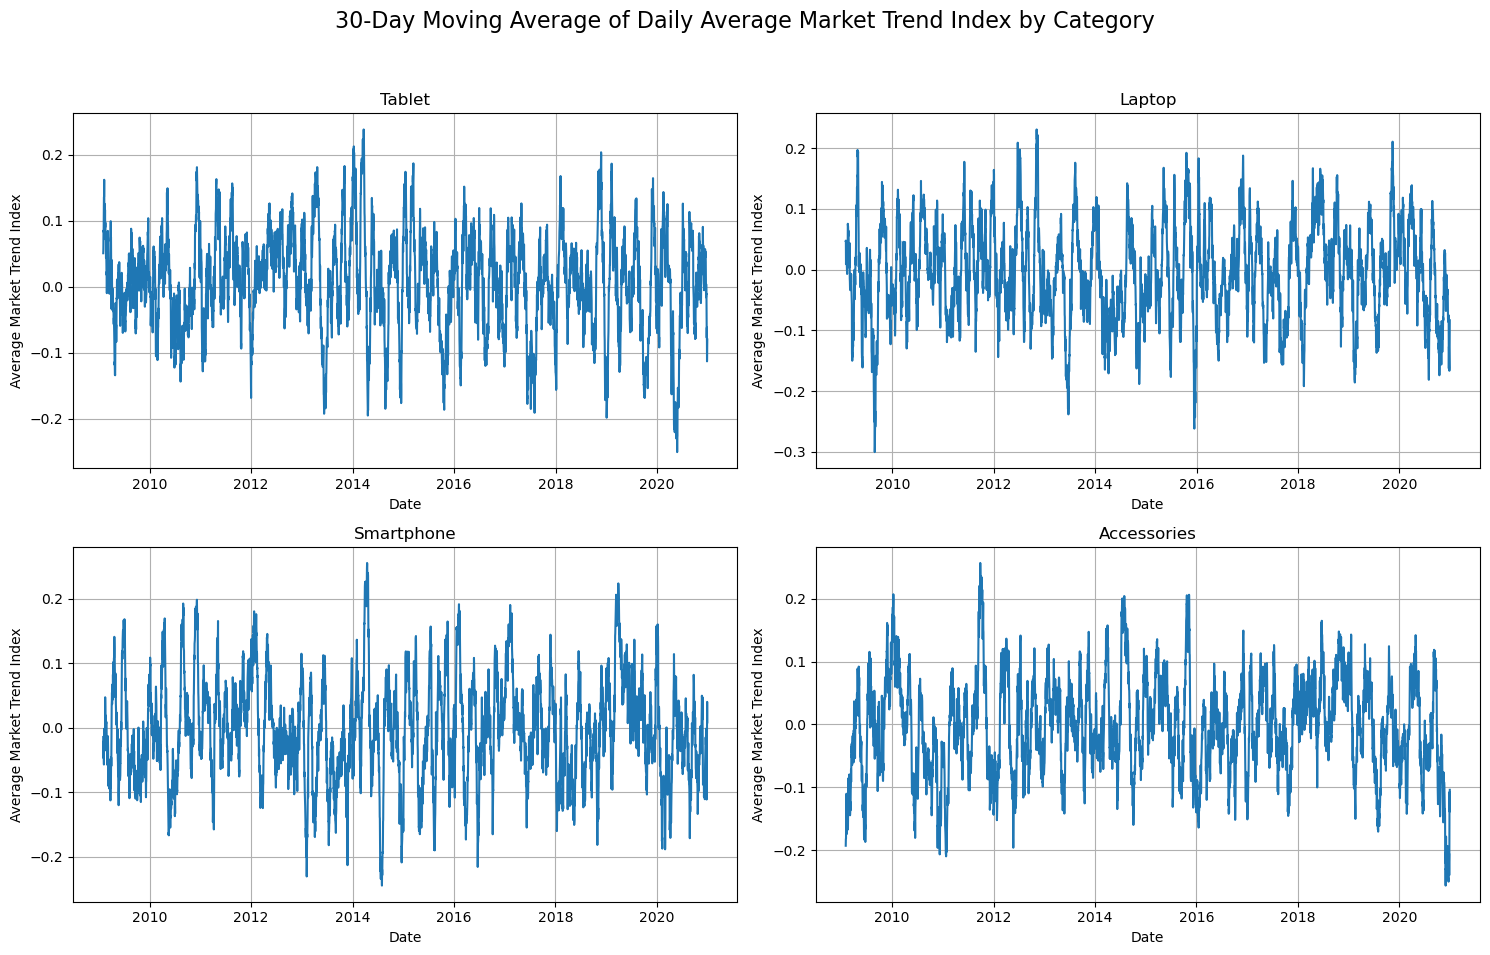

In [14]:
# Group by Date and Category, then calculate average Market_Trend_Index for each day per category
daily_avg_mti_tablet = tablet_df.groupby(['Date', 'Category'])['Market_Trend_Index'].mean().reset_index()
daily_avg_mti_laptop = laptop_df.groupby(['Date', 'Category'])['Market_Trend_Index'].mean().reset_index()
daily_avg_mti_smartphone = smartphone_df.groupby(['Date', 'Category'])['Market_Trend_Index'].mean().reset_index()
daily_avg_mti_accessory = accessory_df.groupby(['Date', 'Category'])['Market_Trend_Index'].mean().reset_index()

# Pivot so each category becomes a column
pivoted_mti_tablet = daily_avg_mti_tablet.pivot(index='Date', columns='Category', values='Market_Trend_Index')
pivoted_mti_laptop = daily_avg_mti_laptop.pivot(index='Date', columns='Category', values='Market_Trend_Index')
pivoted_mti_smartphone = daily_avg_mti_smartphone.pivot(index='Date', columns='Category', values='Market_Trend_Index')
pivoted_mti_accessory = daily_avg_mti_accessory.pivot(index='Date', columns='Category', values='Market_Trend_Index')    

# Apply a moving average (e.g., 30-day window)
smoothed_mti_tablet = pivoted_mti_tablet.rolling(window=30).mean()
smoothed_mti_laptop = pivoted_mti_laptop.rolling(window=30).mean()
smoothed_mti_smartphone = pivoted_mti_smartphone.rolling(window=30).mean()
smoothed_mti_accessory = pivoted_mti_accessory.rolling(window=30).mean()

# List of (data, title) pairs for Market Trend Index
mti_data_list = [
    (smoothed_mti_tablet, 'Tablet'),
    (smoothed_mti_laptop, 'Laptop'),
    (smoothed_mti_smartphone, 'Smartphone'),
    (smoothed_mti_accessory, 'Accessories')
]

# Create 2x2 subplot figure
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('30-Day Moving Average of Daily Average Market Trend Index by Category', fontsize=16)

# Flatten the axes array
axs = axs.flatten()

# Loop to plot each category
for ax, (data, title) in zip(axs, mti_data_list):
    ax.plot(data)
    ax.set_title(title)
    ax.set_ylabel('Average Market Trend Index')
    ax.set_xlabel('Date')
    ax.grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

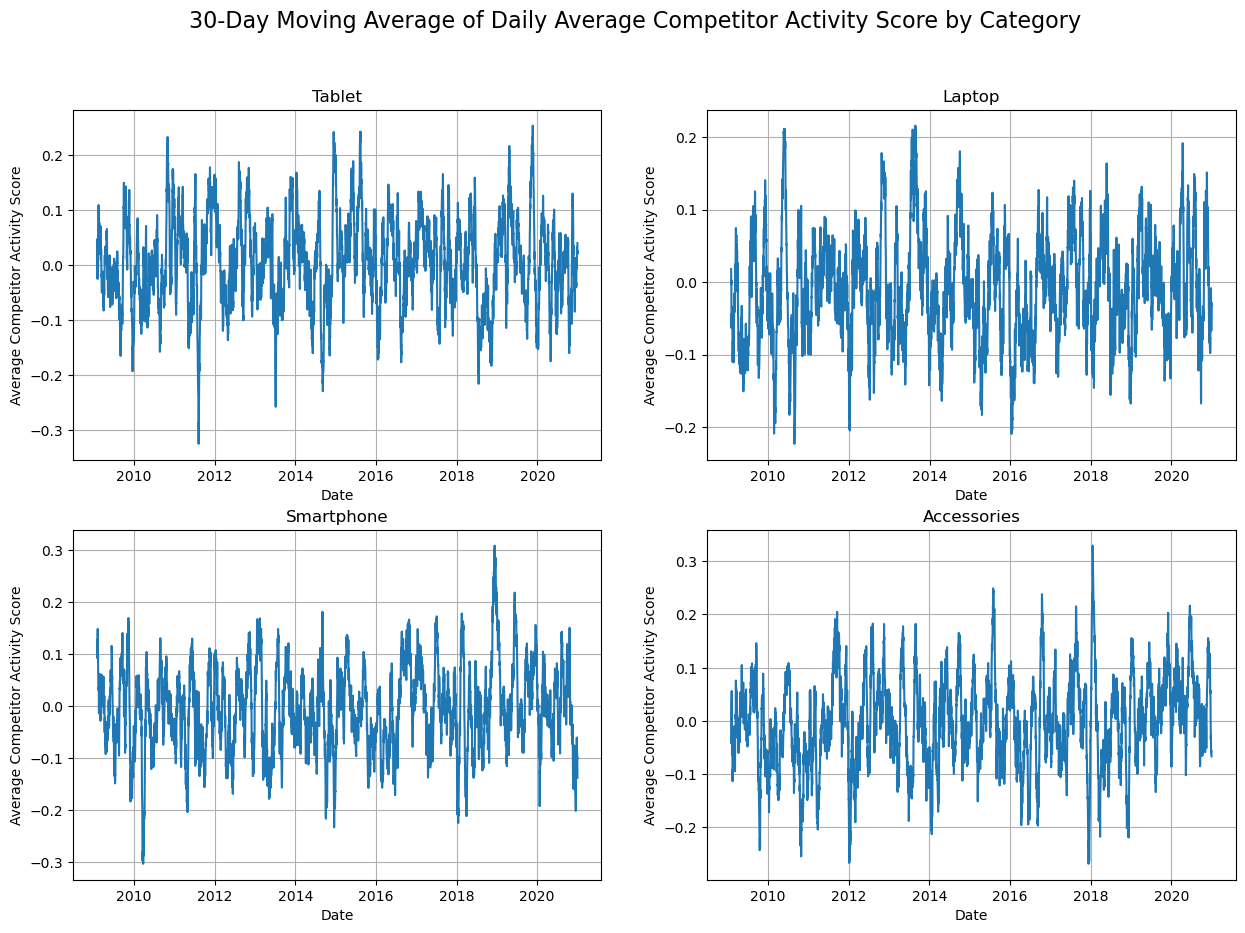

In [15]:
# Group by Date and Category, then calculate average Competitor_Activity_Score for each day per category
daily_avg_cas_tablet = tablet_df.groupby(['Date', 'Category'])['Competitor_Activity_Score'].mean().reset_index()
daily_avg_cas_laptop = laptop_df.groupby(['Date', 'Category'])['Competitor_Activity_Score'].mean().reset_index()
daily_avg_cas_smartphone = smartphone_df.groupby(['Date', 'Category'])['Competitor_Activity_Score'].mean().reset_index()
daily_avg_cas_accessory = accessory_df.groupby(['Date', 'Category'])['Competitor_Activity_Score'].mean().reset_index()  

# Pivot so each category becomes a column
pivoted_cas_tablet = daily_avg_cas_tablet.pivot(index='Date', columns='Category', values='Competitor_Activity_Score')
pivoted_cas_laptop = daily_avg_cas_laptop.pivot(index='Date', columns='Category', values='Competitor_Activity_Score')
pivoted_cas_smartphone = daily_avg_cas_smartphone.pivot(index='Date', columns='Category', values='Competitor_Activity_Score')
pivoted_cas_accessory = daily_avg_cas_accessory.pivot(index='Date', columns='Category', values='Competitor_Activity_Score') 

# Apply a moving average (e.g., 30-day window)
smoothed_cas_tablet = pivoted_cas_tablet.rolling(window=30).mean()
smoothed_cas_laptop = pivoted_cas_laptop.rolling(window=30).mean()
smoothed_cas_smartphone = pivoted_cas_smartphone.rolling(window=30).mean()
smoothed_cas_accessory = pivoted_cas_accessory.rolling(window=30).mean()    

# Create a figure with 4 subplots (2 rows, 2 columns)
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('30-Day Moving Average of Daily Average Competitor Activity Score by Category', fontsize=16)

# Plot for Tablet
axs[0, 0].plot(smoothed_cas_tablet)
axs[0, 0].set_title('Tablet')
axs[0, 0].set_ylabel('Average Competitor Activity Score')
axs[0, 0].set_xlabel('Date')
axs[0, 0].grid(True)

# Plot for Laptop
axs[0, 1].plot(smoothed_cas_laptop)
axs[0, 1].set_title('Laptop')
axs[0, 1].set_ylabel('Average Competitor Activity Score')
axs[0, 1].set_xlabel('Date')
axs[0, 1].grid(True)        

# Plot for Smartphone
axs[1, 0].plot(smoothed_cas_smartphone)
axs[1, 0].set_title('Smartphone')
axs[1, 0].set_ylabel('Average Competitor Activity Score')
axs[1, 0].set_xlabel('Date')
axs[1, 0].grid(True)

# Plot for Accessories
axs[1, 1].plot(smoothed_cas_accessory)
axs[1, 1].set_title('Accessories')          
axs[1, 1].set_ylabel('Average Competitor Activity Score')
axs[1, 1].set_xlabel('Date')
axs[1, 1].grid(True)    

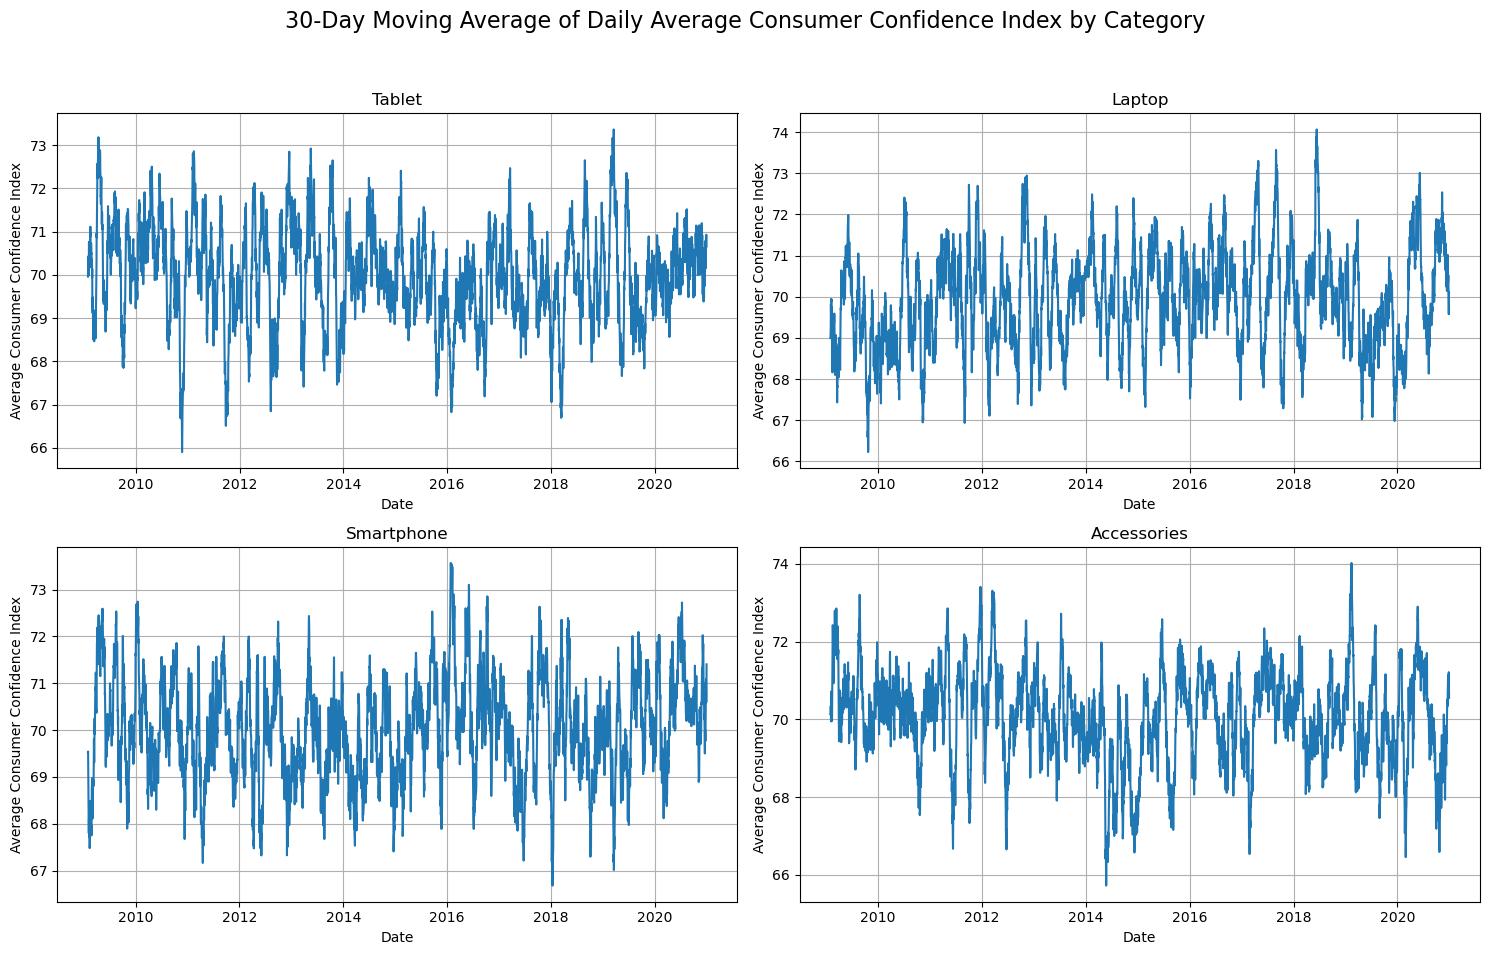

In [16]:
# Group by Date and Category, then calculate average Consumer_Confidence_Index for each day per category
daily_avg_cci_tablet = tablet_df.groupby(['Date', 'Category'])['Consumer_Confidence_Index'].mean().reset_index()
daily_avg_cci_laptop = laptop_df.groupby(['Date', 'Category'])['Consumer_Confidence_Index'].mean().reset_index()
daily_avg_cci_smartphone = smartphone_df.groupby(['Date', 'Category'])['Consumer_Confidence_Index'].mean().reset_index()
daily_avg_cci_accessory = accessory_df.groupby(['Date', 'Category'])['Consumer_Confidence_Index'].mean().reset_index()

# Pivot so each category becomes a column
pivoted_cci_tablet = daily_avg_cci_tablet.pivot(index='Date', columns='Category', values='Consumer_Confidence_Index')
pivoted_cci_laptop = daily_avg_cci_laptop.pivot(index='Date', columns='Category', values='Consumer_Confidence_Index')
pivoted_cci_smartphone = daily_avg_cci_smartphone.pivot(index='Date', columns='Category', values='Consumer_Confidence_Index')
pivoted_cci_accessory = daily_avg_cci_accessory.pivot(index='Date', columns='Category', values='Consumer_Confidence_Index')

# Apply a moving average (e.g., 30-day window)
smoothed_cci_tablet = pivoted_cci_tablet.rolling(window=30).mean()
smoothed_cci_laptop = pivoted_cci_laptop.rolling(window=30).mean()
smoothed_cci_smartphone = pivoted_cci_smartphone.rolling(window=30).mean()
smoothed_cci_accessory = pivoted_cci_accessory.rolling(window=30).mean()

# List of (data, title) pairs for CCI
cci_data_list = [
    (smoothed_cci_tablet, 'Tablet'),
    (smoothed_cci_laptop, 'Laptop'),
    (smoothed_cci_smartphone, 'Smartphone'),
    (smoothed_cci_accessory, 'Accessories')
]

# Create 2x2 subplot figure
fig, axs = plt.subplots(2, 2, figsize=(15, 10))
fig.suptitle('30-Day Moving Average of Daily Average Consumer Confidence Index by Category', fontsize=16)

# Flatten the axes array
axs = axs.flatten()

# Loop through and plot each subplot
for ax, (data, title) in zip(axs, cci_data_list):
    ax.plot(data)
    ax.set_title(title)
    ax.set_ylabel('Average Consumer Confidence Index')
    ax.set_xlabel('Date')
    ax.grid(True)

# Adjust layout
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

In [17]:
tablet_df.columns

Index(['Category', 'Date', 'Sales_Volume', 'Price', 'Market_Trend_Index',
       'Competitor_Activity_Score', 'Consumer_Confidence_Index'],
      dtype='object')

In [18]:
print("Tablet Sales Summary:")
print(smoothed_tablet.describe())

print("Laptop Sales Summary:")
print(smoothed_laptop.describe())

print("Smartphone Sales Summary:")
print(smoothed_smartphone.describe())

print("Accessory Sales Summary:")
print(smoothed_accessory.describe())

Tablet Sales Summary:
Category       Tablet
count     4362.000000
mean       122.710141
std         41.696437
min         44.430897
25%         86.417104
50%        123.826364
75%        158.931657
max        202.211867
Laptop Sales Summary:
Category       Laptop
count     4354.000000
mean       122.678516
std         42.050711
min         43.620536
25%         87.876935
50%        122.702126
75%        159.024392
max        209.744697
Smartphone Sales Summary:
Category   Smartphone
count     4352.000000
mean       122.398754
std         41.926397
min         47.721111
25%         87.197241
50%        121.943547
75%        159.123103
max        209.288532
Accessory Sales Summary:
Category  Accessories
count     4351.000000
mean       122.519504
std         42.043967
min         45.708128
25%         86.736872
50%        122.801557
75%        158.689834
max        207.382143


### **Outliers Treatment**

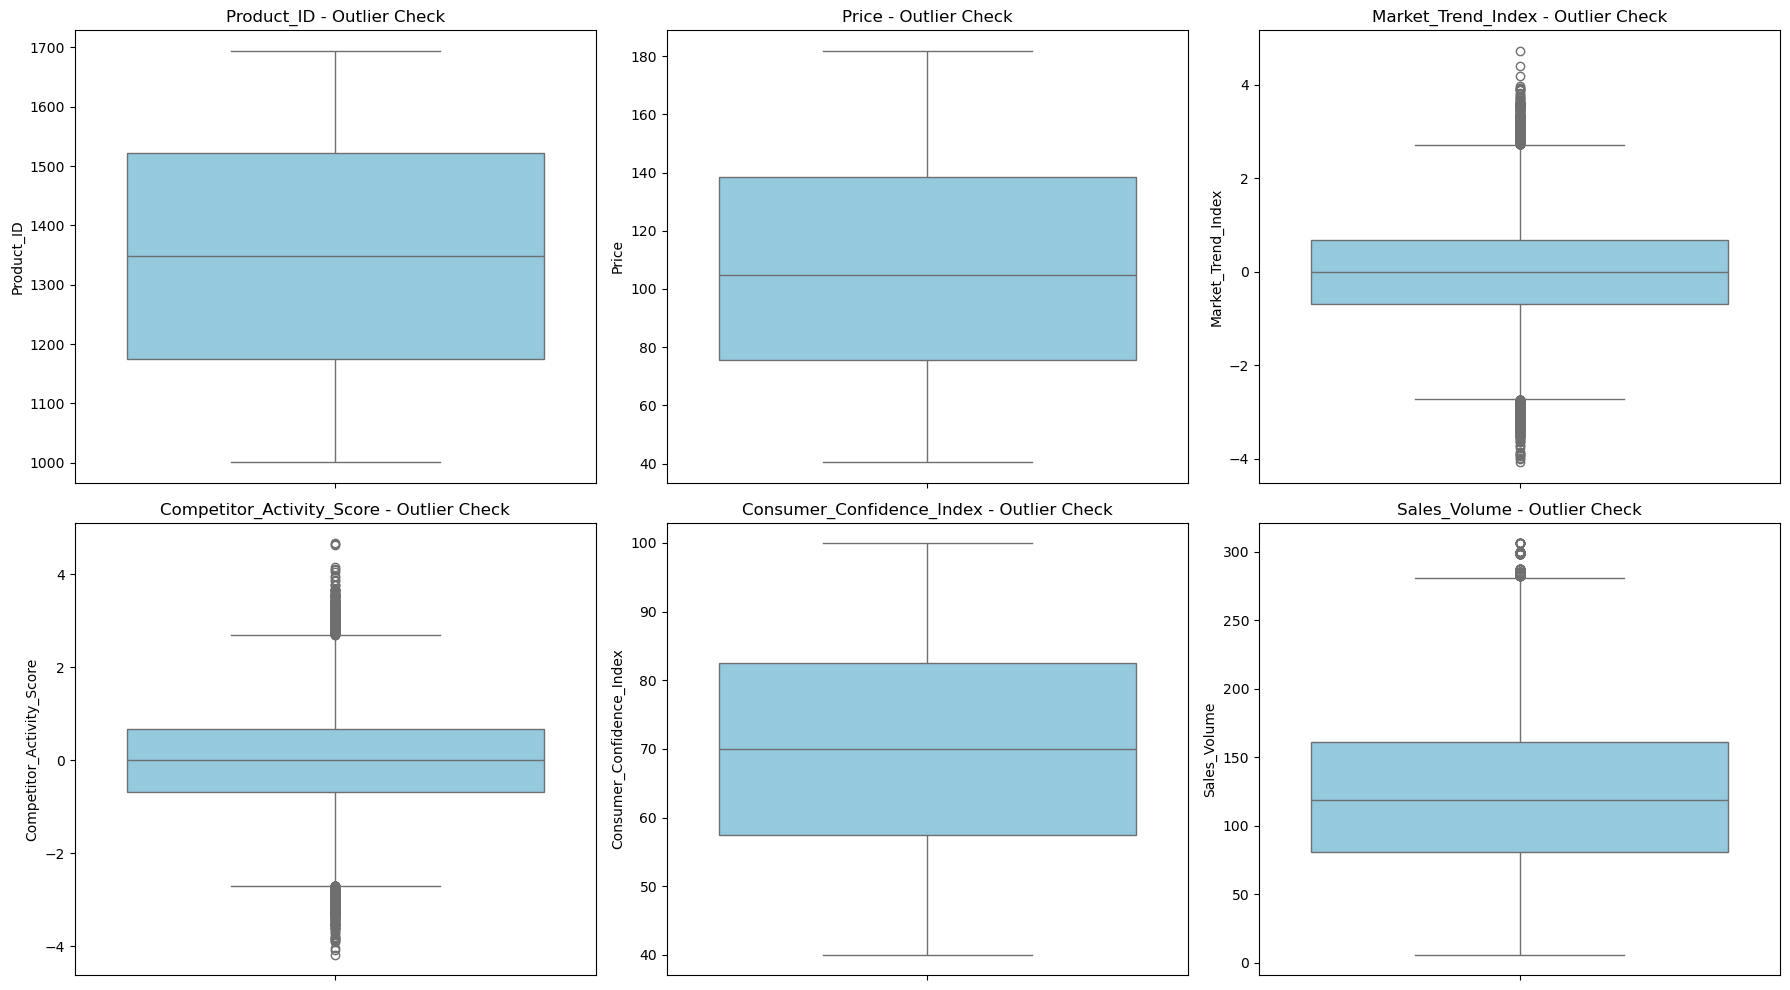

In [19]:
# Check for outliers using sub plots
# Select only numeric columns (or a specific list if needed)
numeric_cols = df.select_dtypes(include='number').columns.tolist()

# Set up the plot grid
n_cols = 3  # Number of columns in the subplot grid
n_rows = -(-len(numeric_cols) // n_cols)  # Ceiling division for rows

# Plot
fig, axes = plt.subplots(n_rows, n_cols, figsize=(6 * n_cols, 5 * n_rows))

for i, col in enumerate(numeric_cols):
    r, c = divmod(i, n_cols)
    ax = axes[r, c] if n_rows > 1 else axes[c]
    sns.boxplot(data=df, y=col, ax=ax, color='skyblue')
    ax.set_title(f'{col} - Outlier Check')
    ax.set_xlabel('')
    ax.set_ylabel(col)

# Remove empty subplots if any
if len(numeric_cols) < n_rows * n_cols:
    for j in range(len(numeric_cols), n_rows * n_cols):
        r, c = divmod(j, n_cols)
        fig.delaxes(axes[r, c] if n_rows > 1 else axes[c])
        
        
plt.tight_layout()
plt.show()
        

In [20]:
# Select only numeric columns
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

print("🔍 Outlier Counts by Column:\n")

for col in numeric_cols:
    col_data = df[col]

    # Compute IQR
    Q1 = col_data.quantile(0.25)
    Q3 = col_data.quantile(0.75)
    IQR = Q3 - Q1

    # Define outlier bounds
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Count outliers
    outlier_count = col_data[(col_data < lower_bound) | (col_data > upper_bound)].count()

    # Only print columns with at least 1 outlier
    if outlier_count > 0:
        print(f"{col}: {outlier_count} outliers")

🔍 Outlier Counts by Column:

Market_Trend_Index: 945 outliers
Competitor_Activity_Score: 959 outliers
Sales_Volume: 182 outliers


In [21]:
# Cap outliers at 25th and 75th percentiles
# Copy the original dataframe
df_capped = df.copy()

# Get only numeric columns
numeric_cols = df_capped.select_dtypes(include=['float64', 'int64']).columns

# Loop through each numeric column and cap outliers
for col in numeric_cols:
    Q1 = df_capped[col].quantile(0.25)
    Q3 = df_capped[col].quantile(0.75)
    IQR = Q3 - Q1

    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR

    # Cap values below the lower bound
    df_capped[col] = df_capped[col].apply(lambda x: lower_bound if x < lower_bound else x)
    
    # Cap values above the upper bound
    df_capped[col] = df_capped[col].apply(lambda x: upper_bound if x > upper_bound else x)
    
# Create a new csv file with capped outliers
df_capped.to_csv('Data_Capped.csv', index=False)


In [22]:
# Compare mean and median of Sales_volume and price to see the effect of treating outliers
print("Mean and Median of Sales Volume Before Capping Outliers:")
print("Sales Volume - Mean:", df['Sales_Volume'].mean())
print("Sales Volume - Median:", df['Sales_Volume'].median())
print("Price - Mean:", df['Price'].mean())
print("Price - Median:", df['Price'].median())
print("\nMean and Median of Sales Volume After Capping Outliers:")
print("Sales Volume - Mean:", df_capped['Sales_Volume'].mean())
print("Sales Volume - Median:", df_capped['Sales_Volume'].median())
print("Price - Mean:", df_capped['Price'].mean())
print("Price - Median:", df_capped['Price'].median())

Mean and Median of Sales Volume Before Capping Outliers:
Sales Volume - Mean: 122.3051404991446
Sales Volume - Median: 119.0
Price - Mean: 106.81251268420552
Price - Median: 104.71

Mean and Median of Sales Volume After Capping Outliers:
Sales Volume - Mean: 122.2939725242854
Sales Volume - Median: 119.0
Price - Mean: 106.81251268420552
Price - Median: 104.71


Based on the results, it proves that the outliers were minimal and caused no distortion or skew to the data, so it is safe to continue analysis with the normal data.

#### **Sales Volume Analysis by Year and Category**

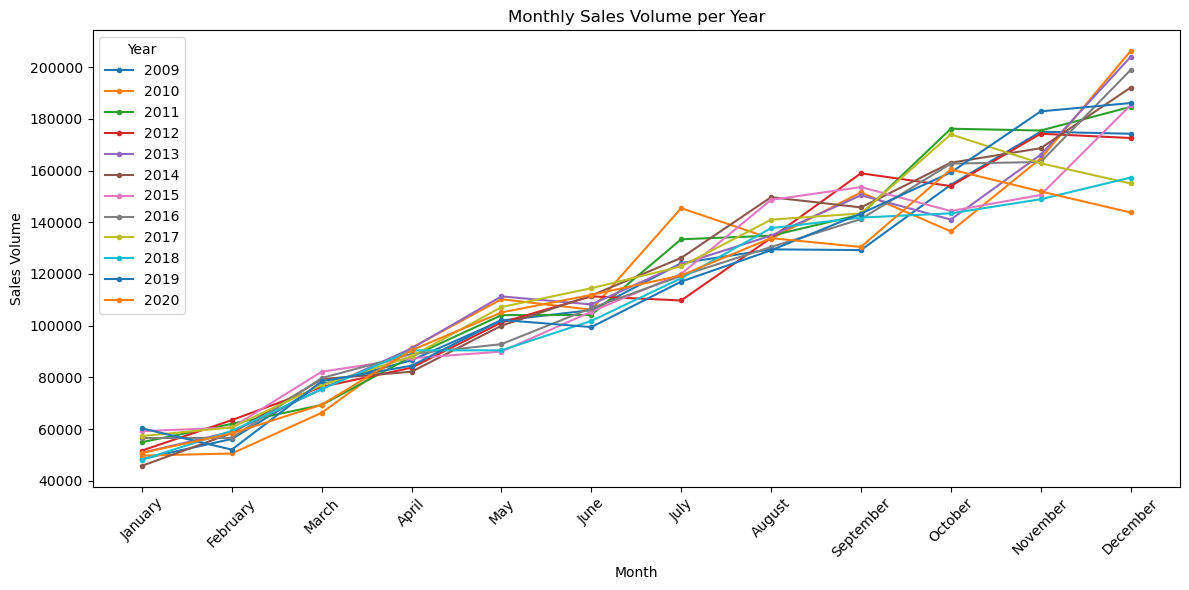

In [42]:
df['Date'] = pd.to_datetime(df['Date'])

# Extract Year and Month for grouping
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.to_period('M').dt.to_timestamp()
df['Month_Name'] = df['Date'].dt.strftime('%B')

# Group by Year and Month
monthly_sales = df.groupby(['Year', 'Month', 'Month_Name'])['Sales_Volume'].sum().reset_index()

# Sort by Month number to ensure correct order
monthly_sales = monthly_sales.sort_values(by='Month')

# Plot
plt.figure(figsize=(12, 6))
for year in monthly_sales['Year'].unique():
    data = monthly_sales[monthly_sales['Year'] == year]
    plt.plot(data['Month_Name'], data['Sales_Volume'], marker = '.', label=str(year))

plt.title('Monthly Sales Volume per Year')
plt.xlabel('Month')
plt.ylabel('Sales Volume')
plt.legend(title='Year')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

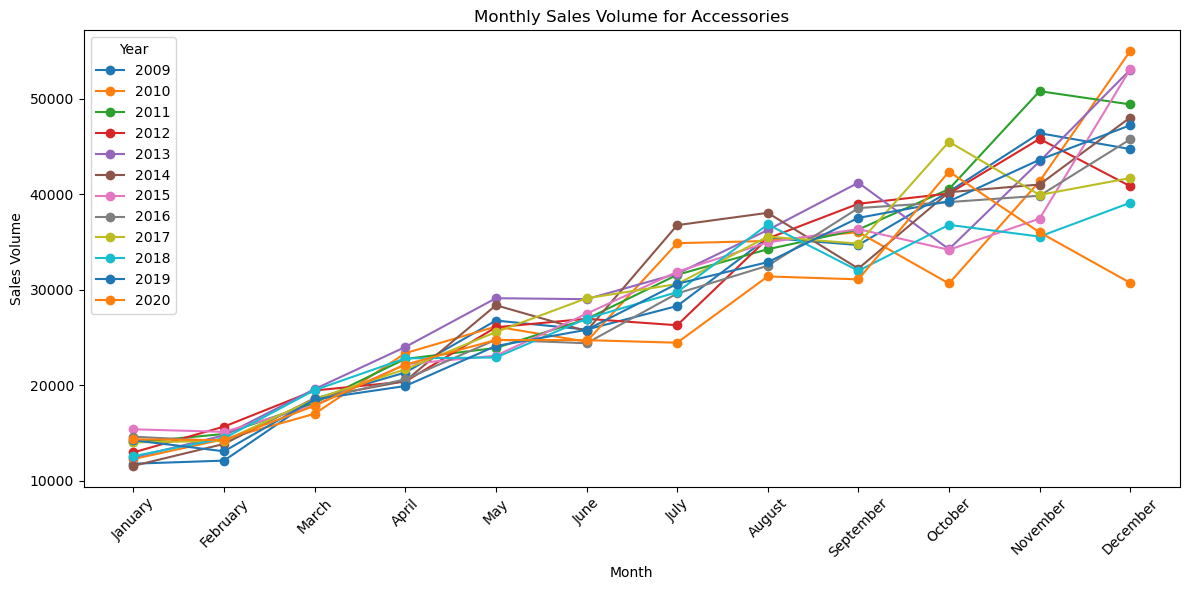

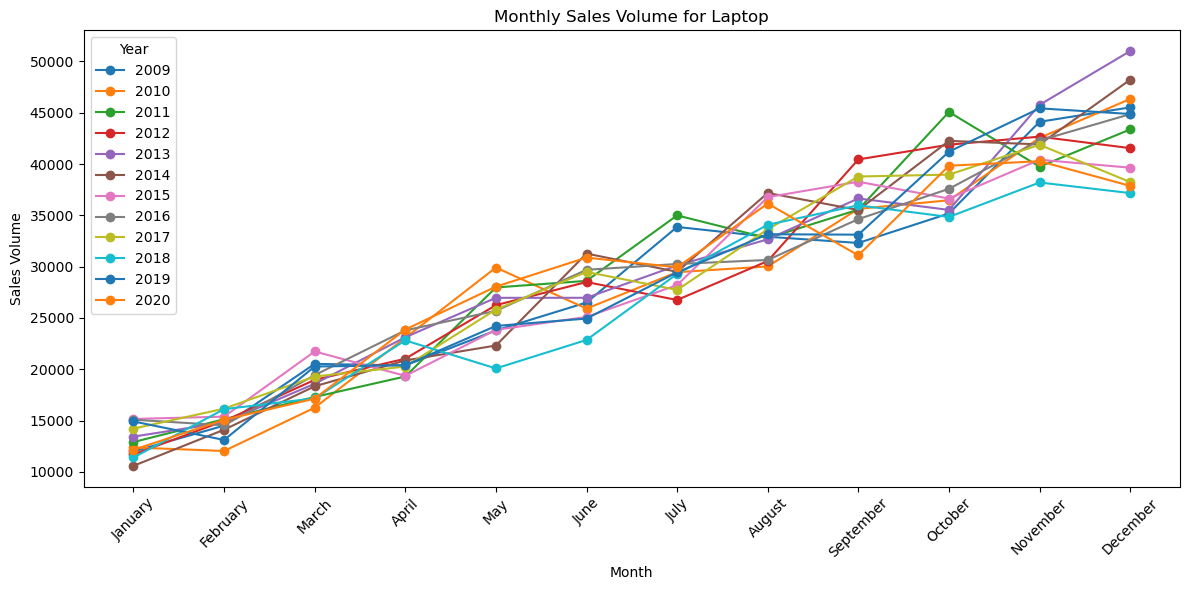

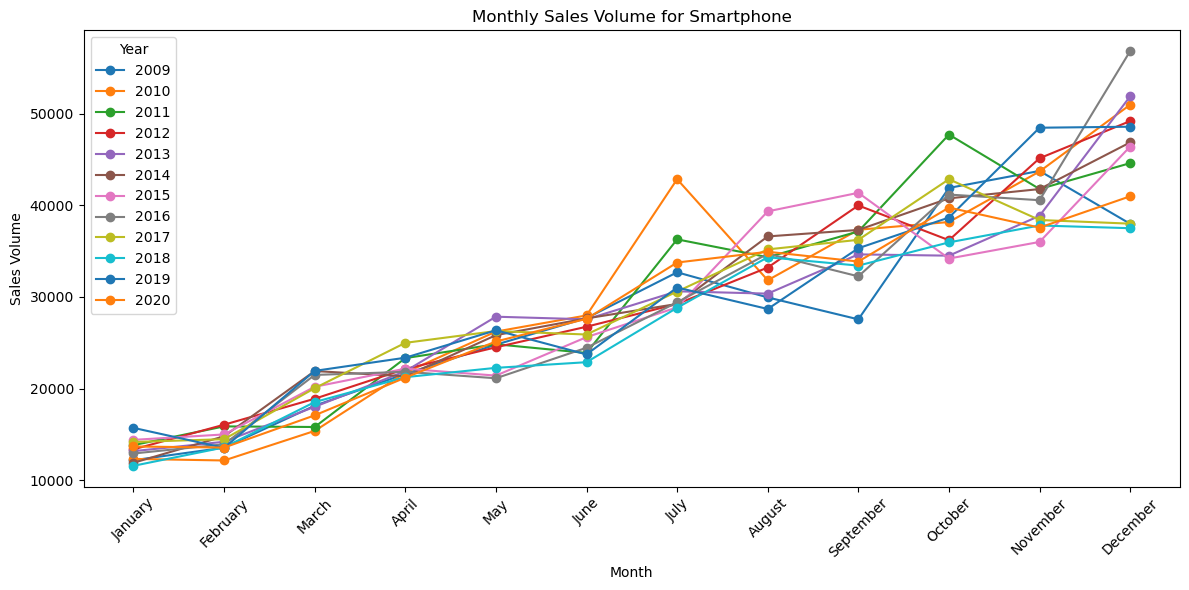

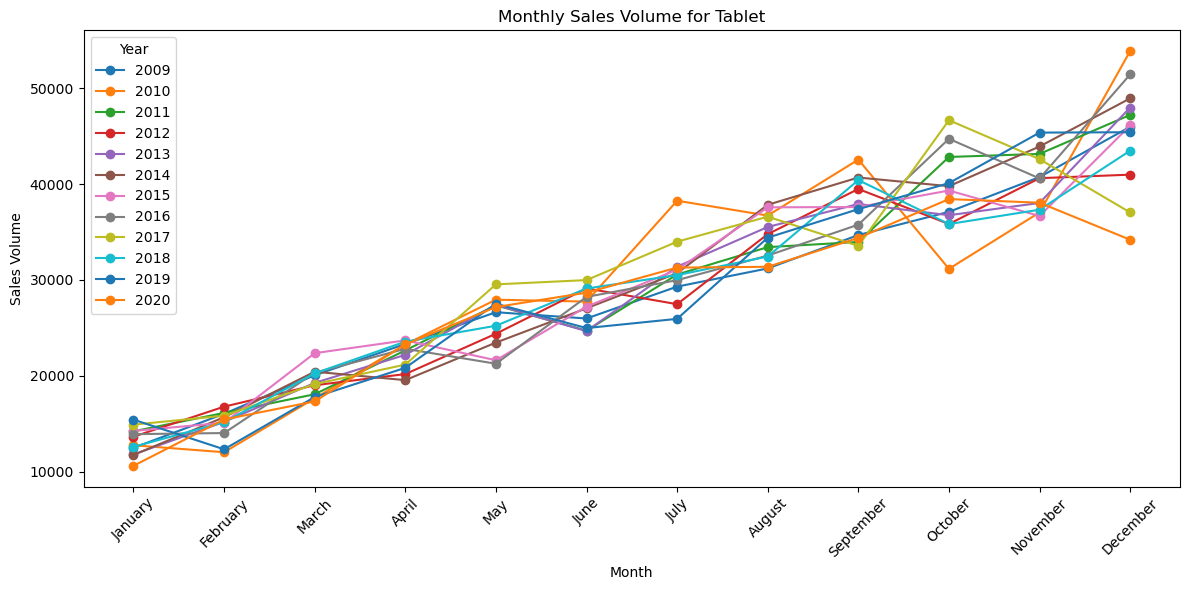

In [43]:
# Group by Category, Year, and Month
grouped = df.groupby(['Category', 'Year', 'Month', 'Month_Name'])['Sales_Volume'].sum().reset_index()

# Sort months to ensure correct x-axis order
grouped = grouped.sort_values(by='Month')

# Get unique categories
categories = grouped['Category'].unique()

# Plot each category separately
for category in categories:
    category_data = grouped[grouped['Category'] == category]
    
    plt.figure(figsize=(12, 6))
    
    for year in category_data['Year'].unique():
        year_data = category_data[category_data['Year'] == year]
        plt.plot(
            year_data['Month_Name'], 
            year_data['Sales_Volume'], 
            marker='o', 
            label=str(year)
        )

    plt.title(f'Monthly Sales Volume for {category}')
    plt.xlabel('Month')
    plt.ylabel('Sales Volume')
    plt.legend(title='Year')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### **Market Trend Index Analysis**

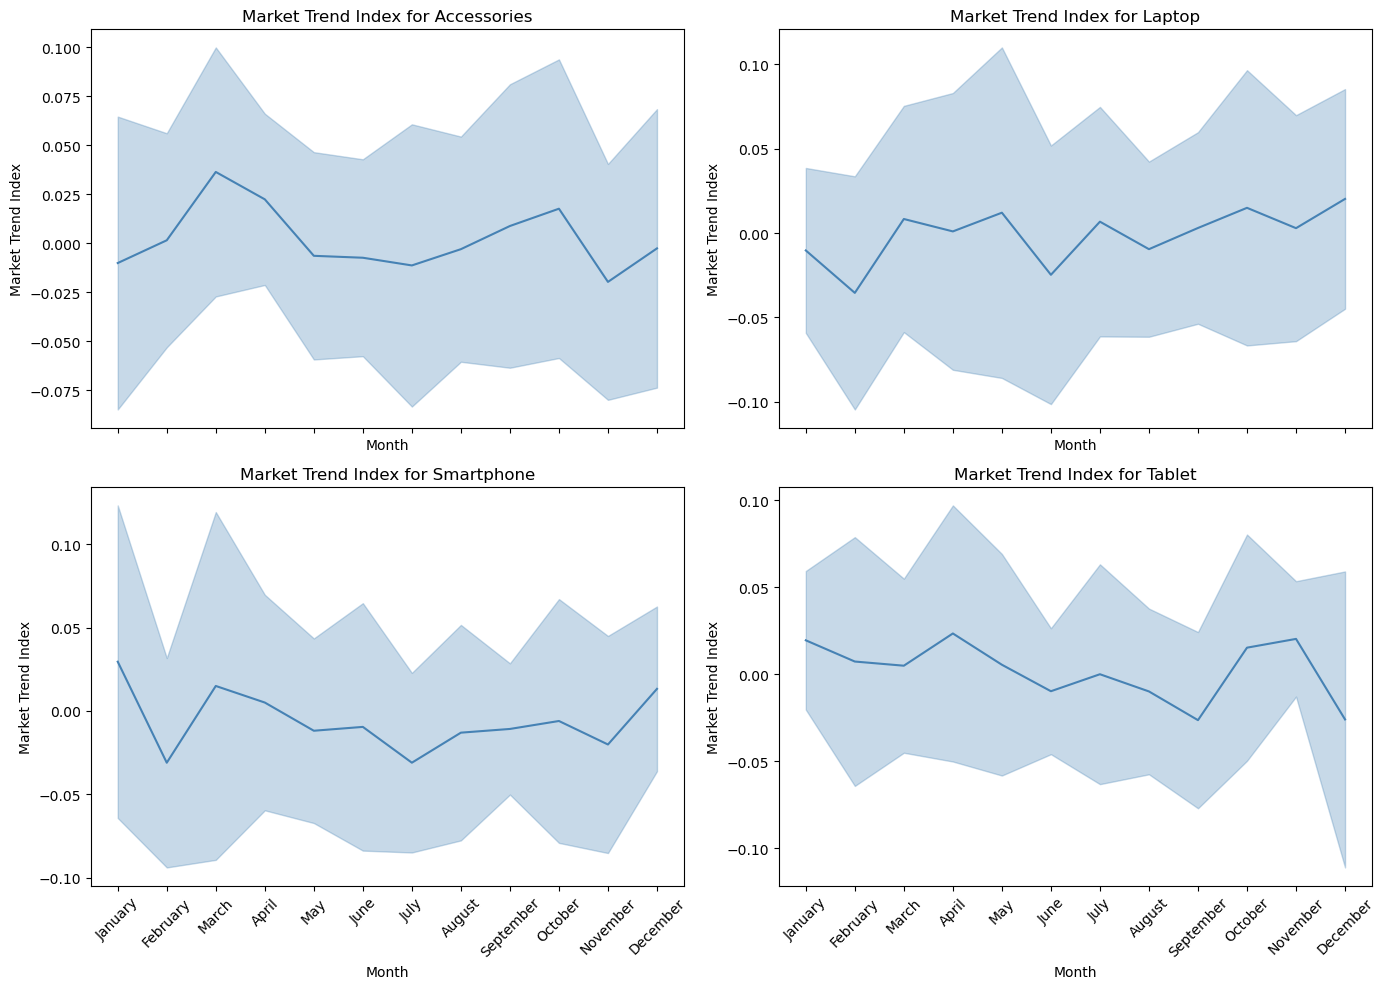

In [ ]:
# Group by Category, Year, and Month to get average Market Trend Index
grouped = (
    df.groupby(['Category', 'Year', 'Month', 'Month_Name'])['Market_Trend_Index']
    .mean()
    .reset_index()
)

# Sort months to ensure proper order
grouped = grouped.sort_values(by='Month')

# Ensure Month_Name is categorical for correct order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month_Name'] = pd.Categorical(df['Month_Name'], categories=month_order, ordered=True)

# Average Market Trend Index per Category-Year-Month
monthly_by_year = df.groupby(['Category', 'Year', 'Month_Name'])['Market_Trend_Index'].mean().reset_index()

# Compute mean and std across years for each (Category, Month)
trend_summary = monthly_by_year.groupby(['Category', 'Month_Name'])['Market_Trend_Index'].agg(['mean', 'std']).reset_index()

# Plot
categories = trend_summary['Category'].unique()
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for i, category in enumerate(categories):
    data = trend_summary[trend_summary['Category'] == category]
    
    ax = axes[i]
    ax.plot(data['Month_Name'], data['mean'], color='steelblue', label='Mean Trend')
    ax.fill_between(
        data['Month_Name'], 
        data['mean'] - data['std'], 
        data['mean'] + data['std'], 
        color='steelblue', alpha=0.3
    )
    ax.set_title(f'Market Trend Index for {category}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Market Trend Index')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### **Competitor Activity Score Analysis**

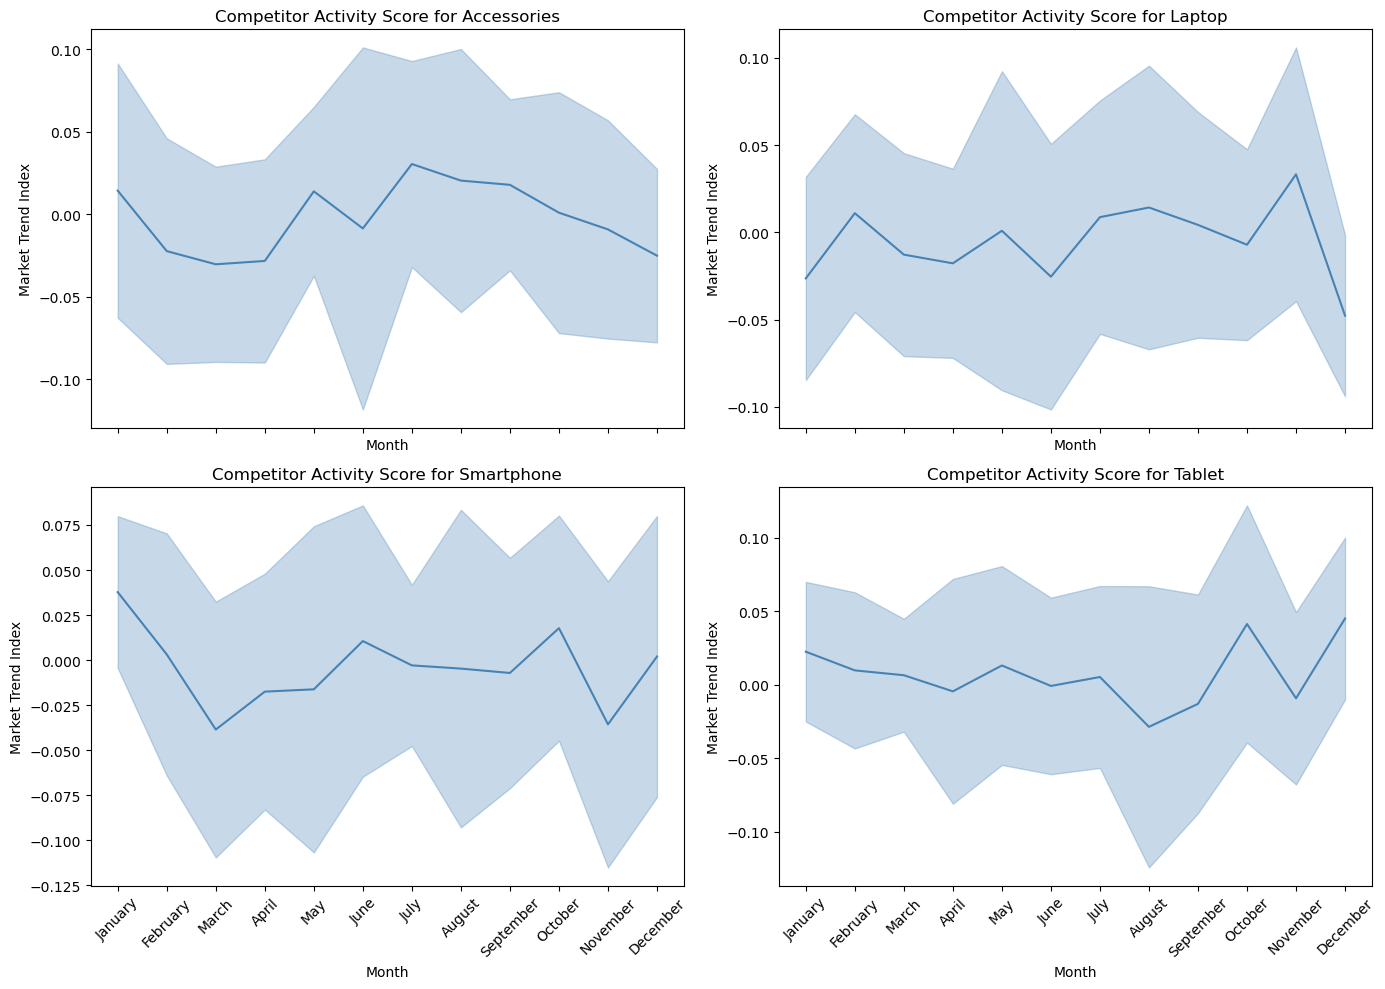

In [52]:
# Group by Category, Year, and Month to get average Market Trend Index
grouped = (
    df.groupby(['Category', 'Year', 'Month', 'Month_Name'])['Competitor_Activity_Score']
    .mean()
    .reset_index()
)

# Sort months to ensure proper order
grouped = grouped.sort_values(by='Month')

# Ensure Month_Name is categorical for correct order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
df['Month_Name'] = pd.Categorical(df['Month_Name'], categories=month_order, ordered=True)

# Average Market Trend Index per Category-Year-Month
monthly_by_year = df.groupby(['Category', 'Year', 'Month_Name'])['Competitor_Activity_Score'].mean().reset_index()

# Compute mean and std across years for each (Category, Month)
trend_summary = monthly_by_year.groupby(['Category', 'Month_Name'])['Competitor_Activity_Score'].agg(['mean', 'std']).reset_index()

# Plot
categories = trend_summary['Category'].unique()
fig, axes = plt.subplots(2, 2, figsize=(14, 10), sharex=True)
axes = axes.flatten()

for i, category in enumerate(categories):
    data = trend_summary[trend_summary['Category'] == category]
    
    ax = axes[i]
    ax.plot(data['Month_Name'], data['mean'], color='steelblue', label='Mean Trend')
    ax.fill_between(
        data['Month_Name'], 
        data['mean'] - data['std'], 
        data['mean'] + data['std'], 
        color='steelblue', alpha=0.3
    )
    ax.set_title(f'Competitor Activity Score for {category}')
    ax.set_xlabel('Month')
    ax.set_ylabel('Market Trend Index')
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

#### **Correlation Between Integer Values**

In [ ]:
# Encode Season to numeric values
season_mapping = {
    'Spring': 1,
    'Summer': 2,        
    'Fall': 3,
    'Winter': 4
}   
df['Season'] = df['Season'].map(season_mapping)

category_mapping = {
    'Tablet': 1,
    'Laptop': 2,
    'Smartphone': 3,
    'Accessories': 4
}
df['Category_Map'] = df['Category'].map(category_mapping)   

Correlation Matrix:
                              Price    Season  Category_Map  \
Price                      1.000000  0.017297     -0.000729   
Season                     0.017297  1.000000      0.003079   
Category_Map              -0.000729  0.003079      1.000000   
Market_Trend_Index        -0.001293 -0.002297     -0.000406   
Competitor_Activity_Score -0.001256  0.004624     -0.002790   
Consumer_Confidence_Index  0.002414 -0.002986      0.001667   
Sales_Volume               0.092713  0.153424      0.001201   

                           Market_Trend_Index  Competitor_Activity_Score  \
Price                               -0.001293                  -0.001256   
Season                              -0.002297                   0.004624   
Category_Map                        -0.000406                  -0.002790   
Market_Trend_Index                   1.000000                  -0.002643   
Competitor_Activity_Score           -0.002643                   1.000000   
Consumer_Confidence

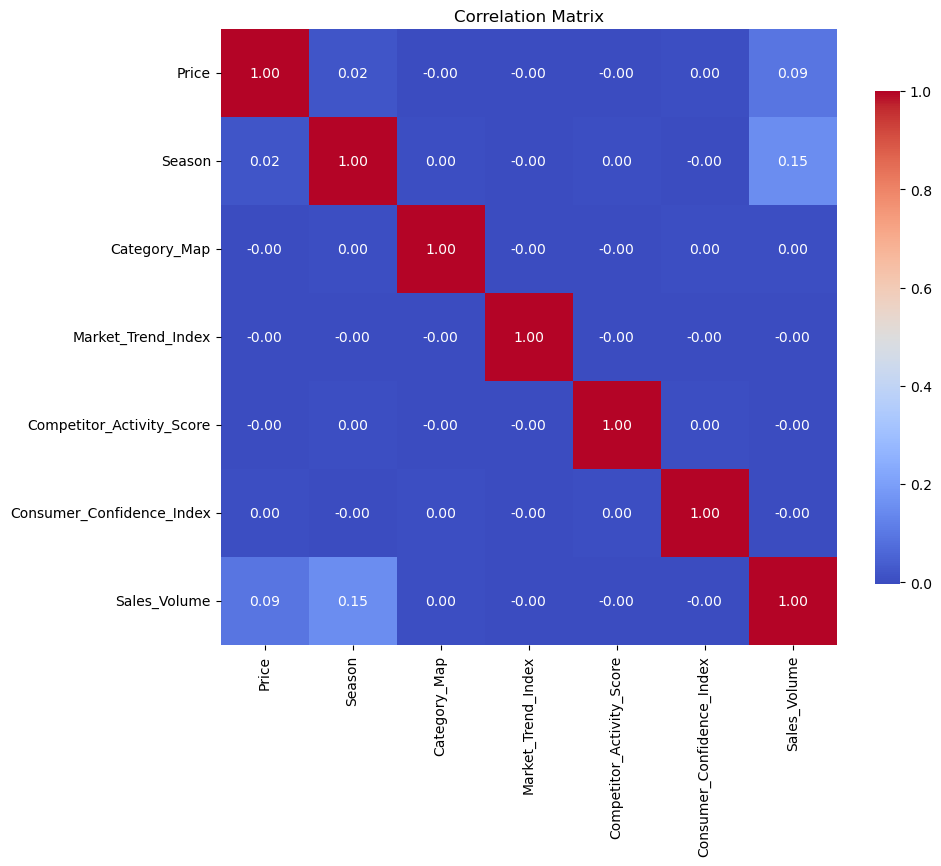

In [60]:
num_cols = df[['Price', 'Season', 'Category_Map',
       'Market_Trend_Index', 'Competitor_Activity_Score',
       'Consumer_Confidence_Index', 'Sales_Volume']]

corr = num_cols.corr()

print("Correlation Matrix:")
print(corr)

# Plot the correlation matrix
plt.figure(figsize=(10, 8))
sns.heatmap(corr, annot=True, fmt=".2f", cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Matrix')
plt.show()  